In [1]:
! ls

'PythonSkLearn-Prediction of Loanpayment-withRAM30GB-AIPlatform-TensorFlow Enterprise 2.5.ipynb'
 accepted_2007_to_2018Q4.csv
 rejected_2007_to_2018Q4.csv
 src
 tutorials


In [2]:
! gsutil cp gs://aekanunlab/lendingclubkaggle/* ./

Copying gs://aekanunlab/lendingclubkaggle/accepted_2007_to_2018Q4.csv...
Copying gs://aekanunlab/lendingclubkaggle/rejected_2007_to_2018Q4.csv...        
| [2 files][  3.2 GiB/  3.2 GiB]  164.2 MiB/s                                   
Operation completed over 2 objects/3.2 GiB.                                      


In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

In [4]:
! pwd

/home/jupyter


In [5]:
loans = pd.read_csv('accepted_2007_to_2018Q4.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [7]:
loans.sample(5).transpose()

,1833105,699552,497060,1291601,1433817
id,5773132,78819950,126625302,14678544,142903250
member_id,NaN,NaN,NaN,NaN,NaN
loan_amnt,16000.0,11000.0,9200.0,13200.0,4000.0
funded_amnt,16000.0,11000.0,9200.0,13200.0,4000.0
funded_amnt_inv,16000.0,11000.0,9200.0,13200.0,4000.0
term,36 months,36 months,36 months,60 months,36 months
int_rate,10.16,6.49,7.97,13.65,7.21
installment,517.48,337.09,288.17,304.76,123.9
grade,B,A,A,C,A
sub_grade,B1,A2,A5,C1,A3


#### ดึง target variable ออกมา

In [8]:
loans['loan_status'].value_counts(dropna=False)

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
NaN                                                         33
Name: loan_status, dtype: int64

#### ตัดเอาเฉพาะบางค่าของ target var.

##### Python: .loc[] ใช้ดึงข้อมูลมาดู แต่เนื่องจาก .loc[] ไม่ใช่ฟังก์ชั่นจึงใช้ [] โดยภายใน [] คือ index ของข้อมูล  .loc[] ต้องการ input 2 อย่าง (1) row index (required) และ (2) column index (optional)

In [9]:
loans = loans.loc[loans['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [10]:
loans.shape

(1345310, 151)

In [11]:
loans['loan_status'].value_counts(dropna=False)

Fully Paid     1076751
Charged Off     268559
Name: loan_status, dtype: int64

In [12]:
loans['loan_status'].value_counts()

Fully Paid     1076751
Charged Off     268559
Name: loan_status, dtype: int64

#### คำนวณ Percentage of Null ในแต่ละ Attributes

In [13]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False)

In [14]:
missing_fractions.head(10)

next_pymnt_d                                  1.000000
member_id                                     1.000000
orig_projected_additional_accrued_interest    0.997206
hardship_start_date                           0.995723
hardship_length                               0.995723
hardship_type                                 0.995723
hardship_reason                               0.995723
hardship_status                               0.995723
deferral_term                                 0.995723
hardship_amount                               0.995723
dtype: float64

Text(0, 0.5, 'Feature count')

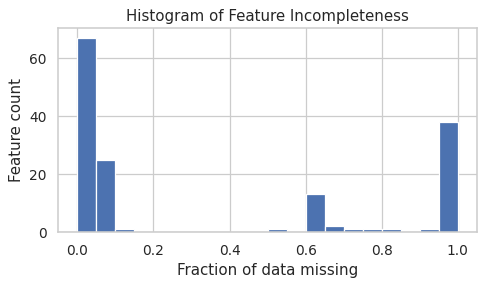

In [15]:
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

##### จากภาพแสดงว่า มี Attribute ที่ NULL เกินกว่า 40% เกินกว่า 40 ตัว

In [16]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

In [17]:
len(drop_list)

58

In [18]:
loans.drop(labels=drop_list, axis=1, inplace=True)

In [19]:
loans.shape

(1345310, 93)

#### Feature Selection with Business Perspective

In [20]:
print(sorted(loans.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sa

##### ชื่อ attributes ที่เป็นที่รู้จักของ Investor ซึ่งต้องการให้ Lending Club ทำการประเมิน Charge off / Fully Paid

In [21]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']

In [22]:
len(keep_list)

31

##### drop attribute ที่ไม่ได้อยู่ใน keep list ออกจาก loans dataframe

In [23]:
drop_list = [col for col in loans.columns if col not in keep_list]
print(drop_list)

['funded_amnt', 'funded_amnt_inv', 'pymnt_plan', 'url', 'delinq_2yrs', 'inq_last_6mths', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc

In [24]:
len(drop_list)

62

In [25]:
loans.drop(labels=drop_list, axis=1, inplace=True)

In [26]:
loans.shape

(1345310, 31)

## EDA

In [27]:
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(loans[col_name], order=sorted(loans[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=loans, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = loans.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

In [28]:
print(list(loans.columns))

['id', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies']


#### id

In [29]:
loans['id'].sample(5)

343466      41398278
334657      43956738
2171339     95196767
510150     126775221
479858     128413622
Name: id, dtype: object

##### id มีค่าที่แตกต่างกันมากเกินไปจึง drop id ทิ้งไป (ไม่มี Pattern ใน id)

In [30]:
loans['id'].describe()

count      1345310
unique     1345310
top       68407277
freq             1
Name: id, dtype: int64

In [31]:
loans.drop('id', axis=1, inplace=True)

#### loan_amnt

In [32]:
loans['loan_amnt'].describe()

count    1.345310e+06
mean     1.441997e+04
std      8.717051e+03
min      5.000000e+02
25%      8.000000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


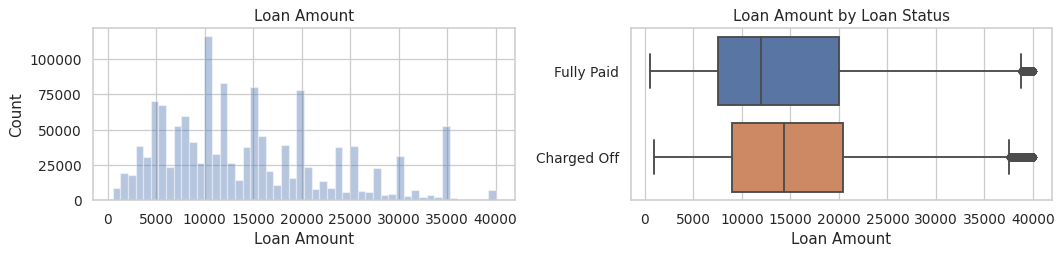

In [33]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

##### จาก BoxPlot เห็นว่า Charged Off มีแนวโน้มการปล่อยกู้แต่ละบัญชีในวงเงินที่สูงกว่า Fully Paid

##### และพบว่ากรณี mean ก็เช่นเดียวกัน

In [34]:
loans.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,15565.055444,8814.560077,900.0,9000.0,14350.0,20400.0,40000.0
Fully Paid,1076751.0,14134.369808,8669.028973,500.0,7500.0,12000.0,20000.0,40000.0


#### term

In [35]:
loans['term'].value_counts(dropna=False)

 36 months    1020743
 60 months     324567
Name: term, dtype: int64

##### แปลงเป็น numeric

In [36]:
loans['term'] = loans['term'].apply(lambda s: np.int8(s.split()[0]))

In [37]:
loans['term'].value_counts(normalize=True)

36    0.758742
60    0.241258
Name: term, dtype: float64

In [38]:
loans.groupby('term')['loan_status'].value_counts(normalize=True)

term  loan_status
36    Fully Paid     0.840066
      Charged Off    0.159934
60    Fully Paid     0.675546
      Charged Off    0.324454
Name: loan_status, dtype: float64

##### ทั้งระยะเวลาของสัญญา 36, 60 เดือน มีคนที่เบี้ยวหนี้ทั้งคู่ แต่จะเห็นว่า 60 เดือน นั้นสูงกว่า

In [39]:
loans.groupby('term')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

term
36    0.159934
60    0.324454
Name: loan_status, dtype: float64

#### int_rate

In [40]:
loans['int_rate'].describe()

count    1.345310e+06
mean     1.323962e+01
std      4.768716e+00
min      5.310000e+00
25%      9.750000e+00
50%      1.274000e+01
75%      1.599000e+01
max      3.099000e+01
Name: int_rate, dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


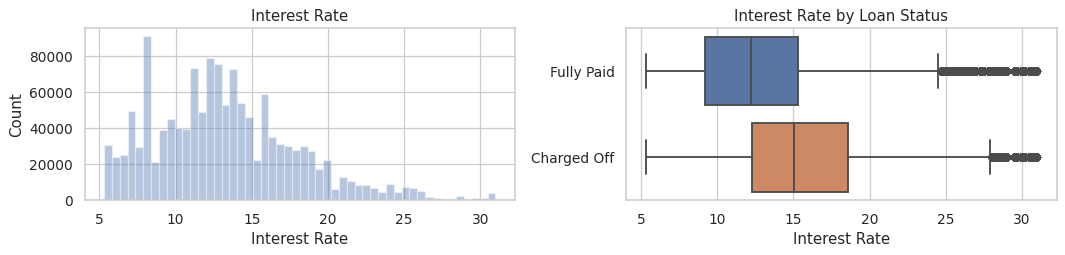

In [41]:
plot_var('int_rate', 'Interest Rate', continuous=True)

In [42]:
loans.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,15.710714,4.910387,5.31,12.29,15.05,18.55,30.99
Fully Paid,1076751.0,12.623288,4.527227,5.31,9.17,12.23,15.31,30.99


#### installation

In [43]:
loans['installment'].describe()

count    1.345310e+06
mean     4.380755e+02
std      2.615126e+02
min      4.930000e+00
25%      2.484800e+02
50%      3.754300e+02
75%      5.807300e+02
max      1.719830e+03
Name: installment, dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


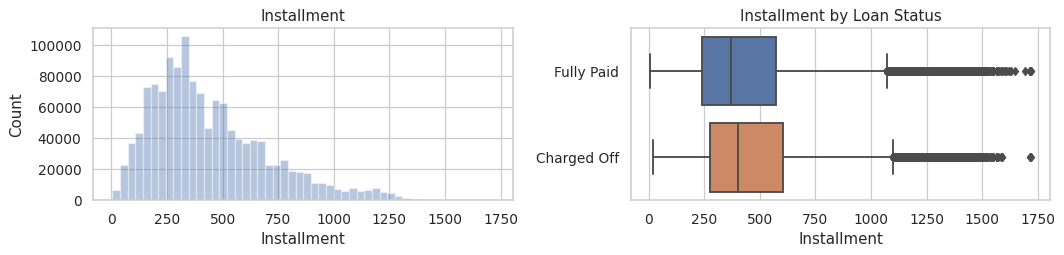

In [44]:
plot_var('installment', 'Installment', continuous=True)

In [45]:
loans.groupby('loan_status')['installment'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,465.147994,262.774106,21.62,275.29,402.83,605.31,1717.63
Fully Paid,1076751.0,431.323226,260.759563,4.93,240.92,368.26,573.06,1719.83


#### grade, sub_grade

In [46]:
print(sorted(loans['grade'].unique()))

['A', 'B', 'C', 'D', 'E', 'F', 'G']


In [47]:
print(sorted(loans['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


In [48]:
loans.drop('grade', axis=1, inplace=True)

In [49]:
loans.groupby('sub_grade')['loan_status'].value_counts(normalize=True).sort_values(ascending=False)\
.loc[:,'Charged Off']

sub_grade
G5    0.536036
G3    0.513631
G4    0.511719
F5    0.491758
G2    0.491319
F4    0.478905
G1    0.478478
F2    0.453459
F3    0.450723
F1    0.422969
E5    0.417701
E4    0.401018
E3    0.387121
E2    0.375450
E1    0.360647
D5    0.334270
D4    0.323680
D3    0.305415
D2    0.295866
D1    0.278054
C5    0.260050
C4    0.249204
C3    0.225233
C2    0.207188
C1    0.189838
B5    0.167014
B4    0.148271
B3    0.129835
B2    0.113598
B1    0.104212
A5    0.084043
A4    0.068670
A3    0.055085
A2    0.046640
A1    0.032236
Name: loan_status, dtype: float64

In [50]:
loans.groupby('sub_grade')['loan_status'].value_counts(normalize=True).sort_values(ascending=False)\
.loc[:,'Fully Paid']

sub_grade
A1    0.967764
A2    0.953360
A3    0.944915
A4    0.931330
A5    0.915957
B1    0.895788
B2    0.886402
B3    0.870165
B4    0.851729
B5    0.832986
C1    0.810162
C2    0.792812
C3    0.774767
C4    0.750796
C5    0.739950
D1    0.721946
D2    0.704134
D3    0.694585
D4    0.676320
D5    0.665730
E1    0.639353
E2    0.624550
E3    0.612879
E4    0.598982
E5    0.582299
F1    0.577031
F3    0.549277
F2    0.546541
G1    0.521522
F4    0.521095
G2    0.508681
F5    0.508242
G4    0.488281
G3    0.486369
G5    0.463964
Name: loan_status, dtype: float64

In [51]:
loans['sub_grade'].value_counts(normalize=True).sort_values(ascending=False)

C1    0.063550
B4    0.061844
B5    0.061352
B3    0.060824
C2    0.058881
C3    0.055748
C4    0.055319
B2    0.055024
B1    0.052890
C5    0.050219
A5    0.047575
A4    0.038827
D1    0.038148
D2    0.033337
A1    0.032467
D3    0.029225
A3    0.028243
A2    0.027635
D4    0.026437
D5    0.022226
E1    0.017653
E2    0.015890
E3    0.013667
E4    0.011685
E5    0.010716
F1    0.007411
F2    0.005350
F3    0.004525
F4    0.003612
F5    0.002931
G1    0.002228
G2    0.001584
G3    0.001200
G4    0.000951
G5    0.000825
Name: sub_grade, dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


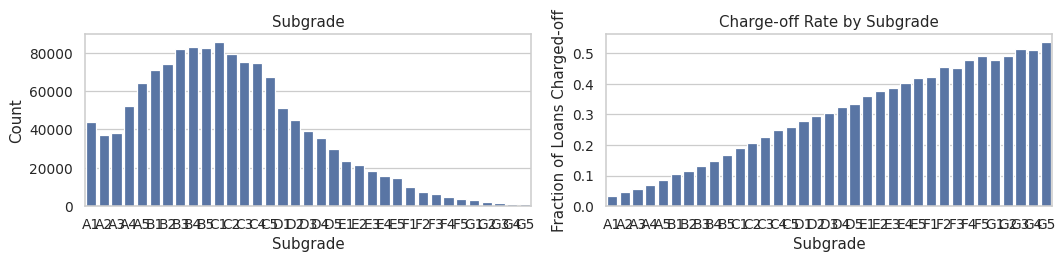

In [52]:
plot_var('sub_grade', 'Subgrade', continuous=False)

##### จากภาพแนวโน้มคนเบี้ยวหนี้เป็นไปตาม sub_grade ที่แย่ตามไปด้วย

In [53]:
loans['emp_length'].value_counts(dropna=False).sort_index()

1 year        88494
10+ years    442199
2 years      121743
3 years      107597
4 years       80556
5 years       84154
6 years       62733
7 years       59624
8 years       60701
9 years       50937
< 1 year     108061
NaN           78511
Name: emp_length, dtype: int64

##### แปลงเป็น numeric

In [54]:
loans['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)

In [55]:
loans['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [56]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])

In [57]:
loans['emp_length'] = loans['emp_length'].apply(emp_length_to_int)

In [58]:
loans['emp_length'].value_counts(dropna=False).sort_index()

0.0     108061
1.0      88494
2.0     121743
3.0     107597
4.0      80556
5.0      84154
6.0      62733
7.0      59624
8.0      60701
9.0      50937
10.0    442199
NaN      78511
Name: emp_length, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


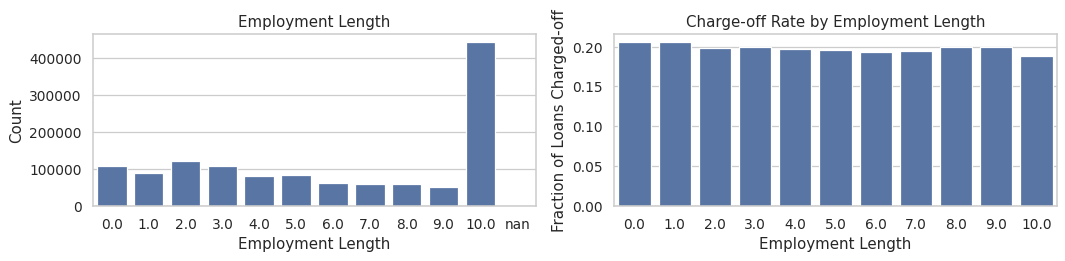

In [59]:
plot_var('emp_length', 'Employment Length', continuous=False)

##### ระยะเวลาการจ้างงานดูจะไม่ค่อยมีผลกับ Charged Off (แต่อาจต้องลอง drop การจ้างงาน 10 ปี ออก อาจจะเห็นผลเปลี่ยนไป)

#### home_ownership

In [60]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    665579
RENT        534421
OWN         144832
ANY            286
OTHER          144
NONE            48
Name: home_ownership, dtype: int64

##### เปลี่ยนให้ any, none เป็น other

In [61]:
loans['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

In [62]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    665579
RENT        534421
OWN         144832
OTHER          478
Name: home_ownership, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


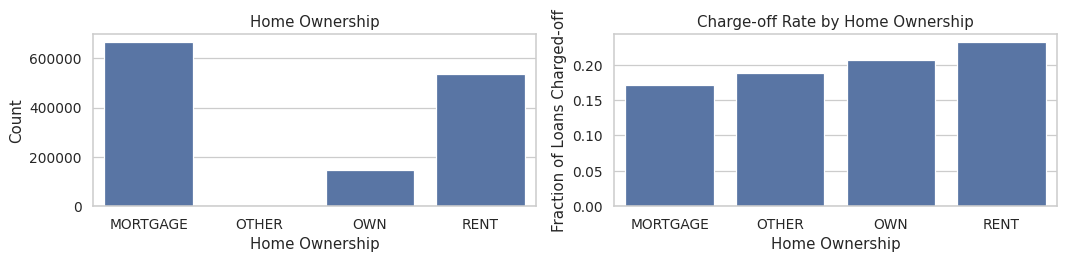

In [63]:
plot_var('home_ownership', 'Home Ownership', continuous=False)

In [64]:
loans.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

home_ownership
MORTGAGE    0.172077
OTHER       0.188285
OWN         0.206198
RENT        0.232165
Name: loan_status, dtype: float64

##### จากภาพจะเห็นว่า คนเช่าบ้าน และมีบ้านเป็นของตนเอง มีโอกาสเบี้ยวหนี้สูงกว่า

#### annual_inc

In [65]:
loans['annual_inc'].describe()

count    1.345310e+06
mean     7.624764e+04
std      6.992510e+04
min      0.000000e+00
25%      4.578000e+04
50%      6.500000e+04
75%      9.000000e+04
max      1.099920e+07
Name: annual_inc, dtype: float64

##### รายได้ต่อปีของผู้ยื่นกู้ มี Range (max-min) ต่างกันมาก จึงควรลดความต่างของค่าลงด้วยการ take log **

In [66]:
loans['log_annual_inc'] = loans['annual_inc'].apply(lambda x: np.log10(x+1))

In [67]:
loans['log_annual_inc'].describe()

count    1.345310e+06
mean     4.812814e+00
std      2.477200e-01
min      0.000000e+00
25%      4.660685e+00
50%      4.812920e+00
75%      4.954247e+00
max      7.041361e+00
Name: log_annual_inc, dtype: float64

In [68]:
loans.drop('annual_inc', axis=1, inplace=True)

In [69]:
loans['log_annual_inc'].describe()

count    1.345310e+06
mean     4.812814e+00
std      2.477200e-01
min      0.000000e+00
25%      4.660685e+00
50%      4.812920e+00
75%      4.954247e+00
max      7.041361e+00
Name: log_annual_inc, dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


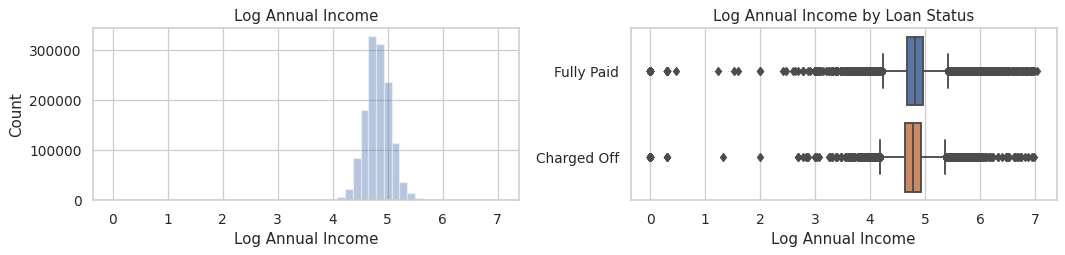

In [70]:
plot_var('log_annual_inc', 'Log Annual Income', continuous=True)

##### จากภาพจะเห็นว่า fully paid กับ charged off ไม่ต่างกันในเชิงรายได้ของผู้กู้

#### verification_status

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


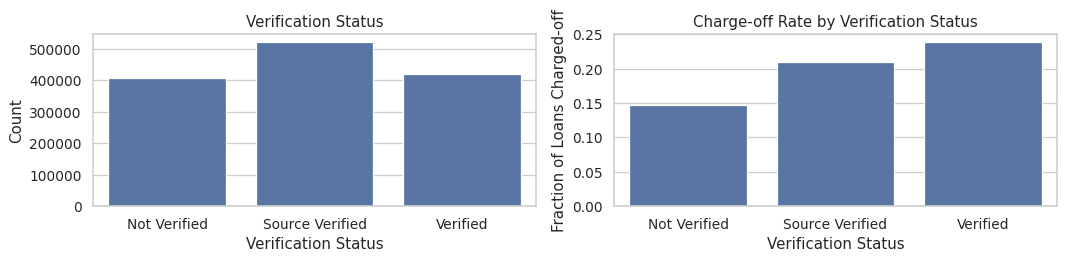

In [71]:
plot_var('verification_status', 'Verification Status', continuous=False)

##### จากภาพเห็นว่า จำนวนผู้กู้ที่เบี้ยวหนี้และ verified แล้ว มีจำนวนมากกว่า จำนวนผู้กู้ที่เบี้ยวหนี้แต่ยังไม่ verified

#### issue_d

##### เนื่องจาก ML Model จะถูกนำไปใช้ predict ว่า fully paid หรือ charged off ซึ่งเป็นการใช้ในช่วงก่อน loan issued แต่ issue_d เป็นข้อมูลหลังจาก loan issued แล้ว จึงควรไม่นำ issue_d มาเป็น feature

## Preprocessing - เปลี่ยนให้เป็น numeric

In [72]:
loans['charged_off'] = (loans['loan_status'] == 'Charged Off').apply(np.uint8)
loans.drop('loan_status', axis=1, inplace=True)

In [73]:
loans.shape

(1345310, 29)

#### ดูว่ามี Missing value มากน้อยแค่ไหน หากไม่มี Missing value ใน Categorical Var. ก็ไม่จำเป็นต้องใช้ NaN dummy variables

In [74]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False) 

In [75]:
print(loans.columns)

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'verification_status',
       'issue_d', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'log_annual_inc', 'charged_off'],
      dtype='object')


In [76]:
loans.shape

(1345310, 29)

In [77]:
loans.sample(5).transpose()

,1669926,1923923,1106212,2181198,1073375
loan_amnt,40000.0,8000.0,18000.0,30200.0,4225.0
term,36,36,36,60,36
int_rate,7.24,13.67,10.78,24.74,16.29
installment,1239.48,272.15,587.43,881.82,149.15
sub_grade,A3,B5,B4,E3,D1
emp_title,Director,Applebee's,Executive Director Employee Relations,UniServ Director,Finance Manager
emp_length,10.0,1.0,10.0,10.0,10.0
home_ownership,RENT,RENT,MORTGAGE,MORTGAGE,OWN
verification_status,Source Verified,Source Verified,Source Verified,Verified,Source Verified
issue_d,Mar-2017,Jun-2012,Jan-2016,Dec-2016,Feb-2016


## Train/Test Split

##### ใช้ข้อมูลเดือนปีเก่ามา train และใช้เดือนปีใหม่ๆ มา test

In [78]:
loans['issue_d'].sample(5)

1064944    Feb-2016
1067422    Feb-2016
1220256    Aug-2014
901158     Jun-2017
1828742    Jul-2013
Name: issue_d, dtype: object

In [79]:
loans['issue_d'].isnull().any()

False

##### convert ให้เป็น datetime format

In [80]:
loans['issue_d'] = pd.to_datetime(loans['issue_d'])

In [81]:
loans['issue_d'].sample(5)

312221    2015-04-01
1265180   2014-05-01
1072109   2016-02-01
1789360   2013-10-01
2084433   2017-11-01
Name: issue_d, dtype: datetime64[ns]

In [82]:
loans['issue_d'].describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                 1345310
unique                    139
top       2016-03-01 00:00:00
freq                    48937
first     2007-06-01 00:00:00
last      2018-12-01 00:00:00
Name: issue_d, dtype: object

##### ผลข้างบน แสดงให้เห็นว่า ในระยะเวลา 11 ปี มีแค่ 139 วัน ที่เป็นวันปล่อยกู้

Text(0.5, 1.0, 'Loans Funded per Year')

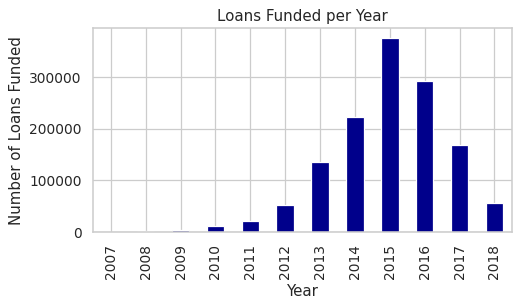

In [83]:
plt.figure(figsize=(6,3), dpi=90)
loans['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of Loans Funded')
plt.title('Loans Funded per Year')

##### ตัดแบ่งมาเป็น testing set เพียงแค่ 10%

In [84]:
loans_train = loans.loc[loans['issue_d'] <  loans['issue_d'].quantile(0.9)].sample(10000).dropna()
loans_test =  loans.loc[loans['issue_d'] >= loans['issue_d'].quantile(0.9)].sample(10000).dropna()

In [85]:
print('Number of loans in the partition:   ', loans_train.shape[0] + loans_test.shape[0])
print('Number of loans in the full dataset:', loans.shape[0])

Number of loans in the partition:    17985
Number of loans in the full dataset: 1345310


In [86]:
loans_test.shape[0]

9112

In [87]:
loans_test.shape[0] / loans.shape[0]

0.006773160089496101

In [88]:
loans_train['issue_d'].describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                    8873
unique                     63
top       2016-03-01 00:00:00
freq                      340
first     2012-03-01 00:00:00
last      2017-05-01 00:00:00
Name: issue_d, dtype: object

In [89]:
loans_test['issue_d'].describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                    9112
unique                     19
top       2017-08-01 00:00:00
freq                     1013
first     2017-06-01 00:00:00
last      2018-12-01 00:00:00
Name: issue_d, dtype: object

##### ไม่ใช้ issue_d ในการ train จึงลบทิ้งไป

In [90]:
loans_train.drop('issue_d', axis=1, inplace=True)
loans_test.drop('issue_d', axis=1, inplace=True)

In [91]:
y_train = loans_train['charged_off']
y_test = loans_test['charged_off']

In [92]:
X_train = loans_train.drop('charged_off', axis=1)
X_test = loans_test.drop('charged_off', axis=1)

In [93]:
del loans_train, loans_test

In [94]:
del loans

# 4. Modeling

## Random Forest Classifier

In [95]:
import pandas as pd
from seaborn import load_dataset
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

In [96]:
categorical = list(X_train.select_dtypes('object').columns)
print(f"Categorical columns are: {categorical}")

numerical = list(X_train.select_dtypes('number').columns)
print(f"Numerical columns are: {numerical}")

Categorical columns are: ['sub_grade', 'emp_title', 'home_ownership', 'verification_status', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'application_type']
Numerical columns are: ['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length', 'dti', 'fico_range_low', 'fico_range_high', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'log_annual_inc']


In [97]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [98]:
# Define custom transformer
class ColumnSelector(BaseEstimator, TransformerMixin):
    """Select only specified columns."""
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

# Define categorical pipeline
cat_pipe = Pipeline([('selector', ColumnSelector(categorical)),
                     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                     ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Define numerical pipeline
num_pipe = Pipeline([('selector', ColumnSelector(numerical))
                     #('imputer', SimpleImputer(strategy='median')),
                     #('scaler', MinMaxScaler())
                    ])

# Combine categorical and numerical pipeline
preprocessor = FeatureUnion(transformer_list=[('cat', cat_pipe),
                                              ('num', num_pipe)])

# Model Training
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', DecisionTreeClassifier(criterion="entropy", max_depth=None))])
pipeline_model = pipe.fit(X_train, y_train)

In [99]:
y_pred = pipeline_model.predict(X_test).flatten()


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (predict/actual):\n", pd.DataFrame(cm))


pipeline_model.score(X_test, y_test)

recall = np.diag(cm) / np.sum(cm, axis=1)
print("\nRecall:\n", pd.Series(recall))

precision = np.diag(cm) / np.sum(cm, axis=0)
print("\nPrecision:\n", pd.Series(precision))


from sklearn.metrics import f1_score
weighted_f1 = f1_score(y_test, y_pred, average="weighted")
print("\nF1 score:\n", weighted_f1)

Confusion Matrix (predict/actual):
       0     1
0  5991  1340
1  1307   474

Recall:
 0    0.817215
1    0.266143
dtype: float64

Precision:
 0    0.820910
1    0.261301
dtype: float64

F1 score:
 0.7105095933350319
